# Definition of Problem

In this capstone project, we will build a machine learning model that can predict severity of car collisions based on collision data in Seattle from 2004 to present. If we can build a good model that can predict severity of accident well, we can also predict the most dangerous area for car accident. Furthermore, we can use this model to allow emergency resources (e.g., ambulance) more efficiently because we can predict where more severe accidents will be.  

# Analysis of Data

To analyze data, data visualization has been used

In [1]:
# Install required packages for ibm-sql
!pip install ipython-sql
!pip install ibm_db 
!pip install ibm_db_sa

  Stored in directory: C:\Users\djdml\AppData\Local\pip\Cache\wheels\80\34\1c\3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built prettytable
  Stored in directory: C:\Users\djdml\AppData\Local\pip\Cache\wheels\84\64\42\10b217b545e8085b72160632c61bfa0909f661dad89326a956
Successfully built ibm-db
  Stored in directory: C:\Users\djdml\AppData\Local\pip\Cache\wheels\7f\0b\94\ecb455e6d4042de08ee2f1b623a1e76d30e4e46f526d3763f3
Successfully built ibm-db-sa


In [2]:
#import required packages
import ibm_db
import ibm_db_sa
import sqlalchemy
import pandas as pd
import numpy as np
%load_ext sql

In [3]:
# SQL database connection
%sql ibm_db_sa://crg16556:l2g391z0bf4c1n-k@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

In [4]:
# Loading data from db2
table1 = %sql select * from Collision

 * ibm_db_sa://crg16556:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


In [5]:
# Making dataframe from data from db2
table_pd = pd.DataFrame(table1)
table_pd.columns = table1.keys

In [6]:
# To explore data, we first describe data
table_pd.describe()

,severitycode,objectid,inckey,coldetkey,intkey,severitycode_1,personcount,pedcount,pedcylcount,vehcount,sdot_colcode,sdotcolnum,st_colcode,seglanekey,crosswalkkey
count,194673.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,189769.000000,194673.000000,1.946730e+05
mean,1.298901,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,22.857822,269.401114,9.782452e+03
std,0.457778,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,14.515985,3315.776055,7.226926e+04
min,1.000000,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000,0.000000e+00
25%,1.000000,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,11.000000,0.000000,0.000000e+00
50%,1.000000,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,16.000000,0.000000,0.000000e+00
75%,2.000000,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,32.000000,0.000000,0.000000e+00
max,2.000000,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,88.000000,525241.000000,5.239700e+06


We can see that the maximum severitycode is 2 while the minimum is 1. 
To see whether our data is imbalanced, we check the percentage of each severitycode

In [24]:
# To draw plots, matplotlib library is imported
import matplotlib.pyplot as plt

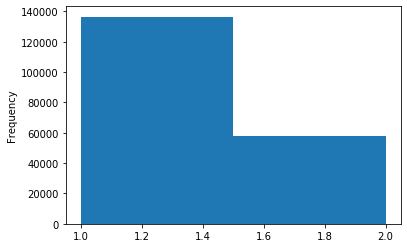

In [25]:
plt.figure()
table_pd['severitycode'].plot.hist(bins=2)

We can see that our data is imbalanced (i.e., non-severe accidents with severity 1 are almost three times more than those with severity 2).

In [26]:
# To check the number of features
# Severity is target, so we ignore this feature
len(table_pd.columns)-1

37

There are 37 features that we can use for training

In [27]:
# To check data types
table_pd.dtypes

severitycode               int64
x                         object
y                         object
objectid                   int64
inckey                     int64
coldetkey                  int64
reportno                  object
status                    object
addrtype                  object
intkey                   float64
location                  object
exceptrsncode             object
exceptrsndesc             object
severitycode_1             int64
severitydesc              object
collisiontype             object
personcount                int64
pedcount                   int64
pedcylcount                int64
vehcount                   int64
incdate           datetime64[ns]
incdttm                   object
junctiontype              object
sdot_colcode               int64
sdot_coldesc              object
inattentionind            object
underinfl                 object
weather                   object
roadcond                  object
lightcond                 object
pedrownotg

In [31]:
# To check weather data, which is possibly useful for training
table_pd['weather'].head(5)

0    Overcast
1     Raining
2    Overcast
3       Clear
4     Raining
Name: weather, dtype: object

In [32]:
# To check road condition, which is possibly useful for training
table_pd['roadcond'].head(5)

0    Wet
1    Wet
2    Dry
3    Dry
4    Wet
Name: roadcond, dtype: object

In [33]:
# To check light condition, which is possibly useful for training
table_pd['lightcond'].head(5)

0                   Daylight
1    Dark - Street Lights On
2                   Daylight
3                   Daylight
4                   Daylight
Name: lightcond, dtype: object

In [36]:
# Speeding can be very informative for severe accident
table_pd['speeding'].head(5)

0    None
1    None
2    None
3    None
4    None
Name: speeding, dtype: object